In [598]:
import dgl
import torch
import dgl
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [599]:
data_dict = {
    ('borrower', 'links to', 'borrower'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
    ('borrower', 'belongs to', 'sector'): (torch.tensor([0, 1, 2]), torch.tensor([0, 1, 1]))
}
g = dgl.heterograph(data_dict)
g

Graph(num_nodes={'borrower': 3, 'sector': 2},
      num_edges={('borrower', 'belongs to', 'sector'): 3, ('borrower', 'links to', 'borrower'): 2},
      metagraph=[('borrower', 'sector', 'belongs to'), ('borrower', 'borrower', 'links to')])

/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: dgl.to_homo is deprecated. Please use dgl.to_homogeneous
  return warnings.warn(message, category=category, stacklevel=1)


{0: Text(-0.7164179104477612, -0.26567164179104474, 'Factor 0'),
 1: Text(-0.3059701492537313, -0.004477611940298511, 'Factor 1'),
 2: Text(-0.2313432835820895, 0.07014925373134327, 'Factor 2'),
 3: Text(-0.6791044776119403, -0.22835820895522385, 'KPI 1'),
 4: Text(-0.45522388059701485, -0.15373134328358207, 'KPI 2'),
 5: Text(-0.1940298507462686, 0.10746268656716416, 'KPI 3'),
 6: Text(0.5895522388059701, -0.0791044776119403, 'KPI 4'),
 7: Text(0.02985074626865674, 0.18208955223880596, 'KPI 5'),
 8: Text(-0.6044776119402985, -0.15373134328358207, 'Fin 1'),
 9: Text(-0.38059701492537307, -0.0791044776119403, 'Fin 2'),
 10: Text(-0.11940298507462682, 0.18208955223880596, 'Fin 3'),
 11: Text(0.6641791044776119, -0.004477611940298511, 'Fin 4'),
 12: Text(0.10447761194029853, 0.25671641791044775, 'Fin 5'),
 13: Text(-0.5671641791044776, -0.11641791044776119, 'Loc 1'),
 14: Text(-0.3432835820895522, -0.041791044776119404, 'Loc 2'),
 15: Text(-0.08208955223880593, 0.21940298507462686, 'Loc 3

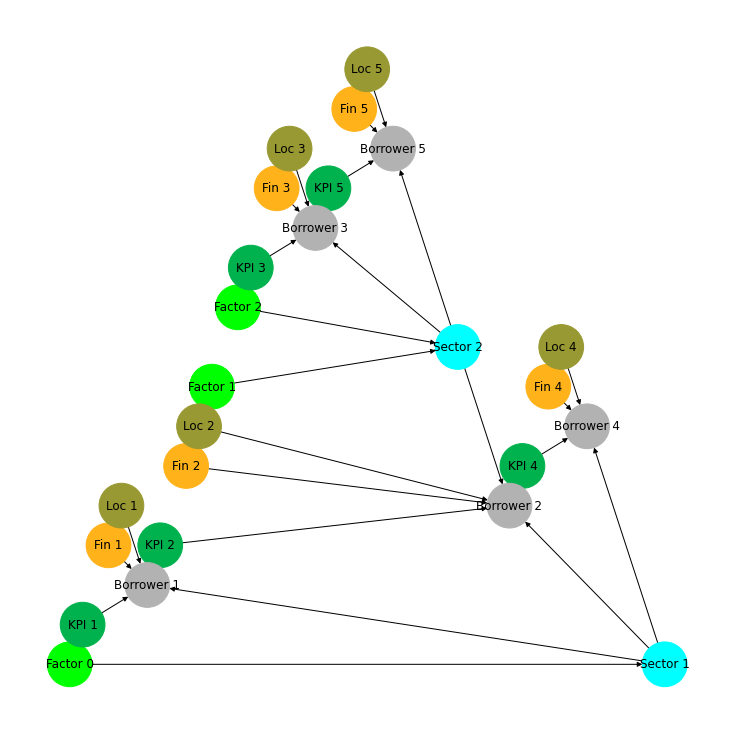

In [600]:
def build_b_s_graph():

    
    b_s_src = np.array([0,1,1,2,3,4])
    b_s_dst = np.array([0,0,1,1,0,1])
    
    data_dict = {
    ('sector', 'belongs', 'borrower'): (torch.tensor(b_s_dst), torch.tensor(b_s_src)),
    ('KPI', 'depends', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    ('Fin', 'are', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    ('Loc', 'is', 'borrower'): (torch.tensor([0,1,2,3,4]), torch.tensor([0,1,2,3,4])),
    ('Factor', 'has', 'sector'): (torch.tensor([0,1,2]), torch.tensor([0,1,1]))
    }

    return dgl.heterograph(data_dict)

sG = build_b_s_graph()
#sG = dgl.add_self_loop(sG)
sG_homo = dgl.to_homo(sG)
snx_G = sG_homo.to_networkx()
pos = nx.planar_layout(snx_G)

codes = torch.tensor([3,3,3,6,6,6,6,6,1,1,1,1,1,5,5,5,5,5,0,0,0,0,0,2,2])
colors = torch.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])

labels={0:'Factor 0',1:'Factor 1',2:'Factor 2',3:'KPI 1',4:'KPI 2',5:'KPI 3',6:'KPI 4',7:'KPI 5',8:'Fin 1',9:'Fin 2',
       10:'Fin 3',11:'Fin 4',12:'Fin 5',13:'Loc 1',14:'Loc 2',15:'Loc 3',16:'Loc 4',17:'Loc 5',18:'Borrower 1',
       19:'Borrower 2',20:'Borrower 3',21:'Borrower 4',22:'Borrower 5',23:'Sector 1',24:'Sector 2'}
plt.figure(figsize=(10, 10))
nx.draw(snx_G, pos, with_labels=False, node_size = 2000, node_color = colors[codes])
nx.draw_networkx_labels(snx_G, pos,labels)
#nx.draw(snx_G, pos, with_labels=True, node_color=colors[codes])


In [604]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(in_feats, hid_feats) for rel in rel_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: dgl.nn.GraphConv(hid_feats, out_feats) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        print("layer1 : ",h)
        h = {k: F.relu(v) for k, v in h.items()}
        #print("AFter Relu : ",h)
        h = self.conv2(graph, h)
        print("layer 2 : ",h)
        return h

In [607]:
sG.nodes['borrower'].data['feature'] = torch.tensor([[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],
[0, 0, 0, 0, 1]])

sG.nodes['KPI'].data['feature'] = torch.tensor([[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],[0, 0, 0, 0, 1],
[0, 0, 0, 0, 1]])

sG.nodes['Fin'].data['feature'] = torch.tensor([[0, 0, 0, 0, 10],[0, 0, 0, 0, 99],[0, 0, 0, 0, 101],[0, 0, 0, 0, 15],
[0, 0, 0, 0, 105]])

sG.nodes['Loc'].data['feature'] = torch.tensor([[0,8, 8, 1, 0],[2, 0, 7, 4, 0],[0, 8, 8, 2, 3],[0, 8, 8, 1, 4],
[2, 0, 7, 4, 2]])

sG.nodes['Factor'].data['feature'] = torch.tensor([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 0, 1]])

sG.nodes['sector'].data['feature'] = torch.tensor([[0, 1, 1, 0, 1],[0, 1, 0, 0, 1]])

# Only sectors are labeled 
#sG.nodes['sector'].data['label'] = torch.tensor([0,1])

layer1 :  {'borrower': tensor([[ -1.2344,   1.9258,  -6.1890,  -2.4138, -14.9146],
        [ -2.0944, -44.8823,  -8.6356,  14.5078, -62.1194],
        [ -3.8180, -43.2357, -13.3756,  12.6056, -66.7966],
        [ -3.0600,  -0.4593,  -8.8549,  -3.1570, -16.1772],
        [ -3.0061, -47.9237, -10.0738,  15.0068, -64.6541]],
       grad_fn=<SumBackward1>), 'sector': tensor([[ 1.2343, -0.6022, -1.6202,  0.2326, -0.6383],
        [ 1.4213, -1.3540, -2.1262,  0.1575, -1.1582]], grad_fn=<SumBackward1>)}
layer 2 :  {'borrower': tensor([[ 0.1142, -0.0547, -0.1487],
        [ 0.1449, -0.1001, -0.2570],
        [ 0.0907, -0.0869, -0.2148],
        [ 0.1142, -0.0547, -0.1487],
        [ 0.0907, -0.0869, -0.2148]], grad_fn=<SumBackward1>)}
tensor([[ 0.1142, -0.0547, -0.1487],
        [ 0.1449, -0.1001, -0.2570],
        [ 0.0907, -0.0869, -0.2148],
        [ 0.1142, -0.0547, -0.1487],
        [ 0.0907, -0.0869, -0.2148]], grad_fn=<SumBackward1>)


{0: Text(-0.7164179104477612, -0.26567164179104474, 'Factor 0'),
 1: Text(-0.3059701492537313, -0.004477611940298511, 'Factor 1'),
 2: Text(-0.2313432835820895, 0.07014925373134327, 'Factor 2'),
 3: Text(-0.6791044776119403, -0.22835820895522385, 'KPI 1'),
 4: Text(-0.45522388059701485, -0.15373134328358207, 'KPI 2'),
 5: Text(-0.1940298507462686, 0.10746268656716416, 'KPI 3'),
 6: Text(0.5895522388059701, -0.0791044776119403, 'KPI 4'),
 7: Text(0.02985074626865674, 0.18208955223880596, 'KPI 5'),
 8: Text(-0.6044776119402985, -0.15373134328358207, 'Fin 1'),
 9: Text(-0.38059701492537307, -0.0791044776119403, 'Fin 2'),
 10: Text(-0.11940298507462682, 0.18208955223880596, 'Fin 3'),
 11: Text(0.6641791044776119, -0.004477611940298511, 'Fin 4'),
 12: Text(0.10447761194029853, 0.25671641791044775, 'Fin 5'),
 13: Text(-0.5671641791044776, -0.11641791044776119, 'Loc 1'),
 14: Text(-0.3432835820895522, -0.041791044776119404, 'Loc 2'),
 15: Text(-0.08208955223880593, 0.21940298507462686, 'Loc 3

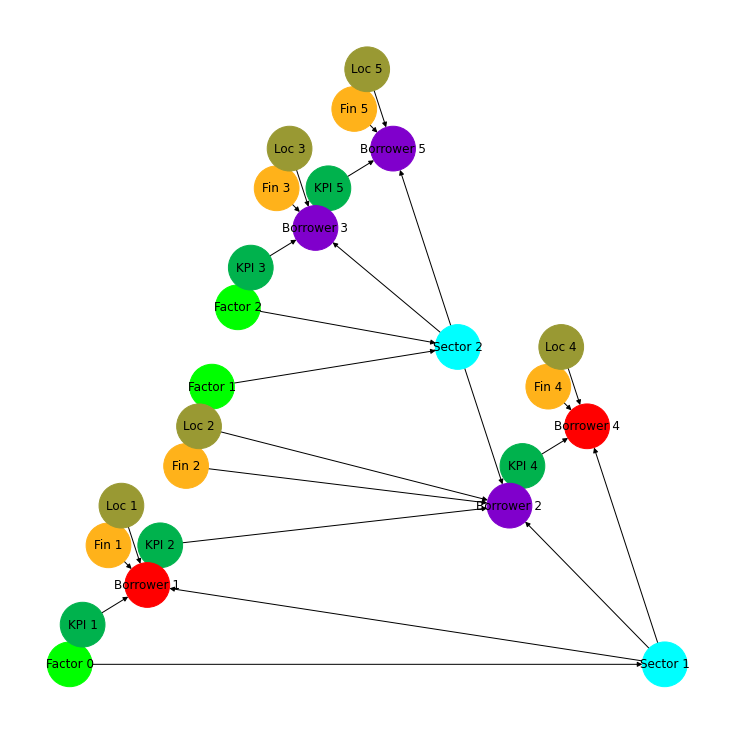

In [609]:
model = RGCN(5, 5, 5, sG.etypes)
borrower_feats = sG.nodes['borrower'].data['feature']
sector_feats = sG.nodes['sector'].data['feature']
kpi_feats = sG.nodes['KPI'].data['feature']
fin_feats = sG.nodes['Fin'].data['feature']
loc_feats = sG.nodes['Loc'].data['feature']
factor_feats = sG.nodes['Factor'].data['feature']

b_labels = torch.tensor([0,1])
labeled_borrowers = torch.tensor([0, 4])

node_features = {'borrower':borrower_feats,'sector':sector_feats,'KPI':kpi_feats, 'Fin':fin_feats, 'Loc':loc_feats,'Factor':factor_feats}
#node_features = {'borrower':borrower_feats,'Factor':factor_feats,'sector':sector_feats}

opt = torch.optim.Adam(model.parameters())

for epoch in range(1):
    model.train()
    # forward propagation by using all nodes and extracting the user embeddings
    logits = model(sG, node_features)

    loss = F.cross_entropy(logits['borrower'][labeled_borrowers], b_labels)

    opt.zero_grad()
    loss.backward()
    opt.step()
    

b_colors = torch.tensor([[.5,0,.8],[1,0,0]])
o_colors = torch.tensor([[.7, .7, .7],[1,.7,.1],[0,1,1],[0,1,0],[1,0,0],[.6,.6,.2],[0,.7,.3]])
c = torch.tensor([3,3,3,6,6,6,6,6,1,1,1,1,1,5,5,5,5,5])

print(logits['borrower'])
X = logits['borrower'].detach().numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

prediction = torch.tensor(kmeans.predict(X)).long()

colors = torch.cat((o_colors[c],b_colors[prediction]))
# nx.draw(snx_G, pos, with_labels=True, node_color = torch.cat((colors,o_colors[[2,2]])))

plt.figure(figsize=(10, 10))
nx.draw(snx_G, pos, with_labels=False, node_size = 2000, node_color = torch.cat((colors,o_colors[[2,2]])))
nx.draw_networkx_labels(snx_G, pos,labels)